In [8]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import addict
import json
import os
import copy
import sys
import numpy as np
import pandas as pd
import matplotlib
%matplotlib ipympl
import matplotlib.pyplot as plt
from importlib import reload
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple

import pyproj
# Global constants
GEOID = pyproj.Geod(ellps="WGS84")
KM2M = 1.0e3
M2MM = 1.0e3
RADIUS_EARTH = np.float64((GEOID.a + GEOID.b) / 2)

import celeri

# Read in data files, create storage dictionaries, and do basic processing

In [10]:
# Western North America example
# command_file_name = "../data/command/western_north_america_command.json"
# Japan model
command_file_name = "../data/command/japan_command.json"

In [11]:
command = celeri.get_command(command_file_name)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
# Update mesh_parameters list
with open(command.mesh_parameters_file_name) as f:
    mesh_param = json.load(f)
# Get mesh directory
mesh_dir = os.path.dirname(mesh_param[0]["mesh_filename"])
# Get stem of segment file name
seg_file_stem = os.path.splitext(os.path.basename(command.segment_file_name))[0]
n_meshes = len(meshes) # Number of preexisting meshes 
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
# Returning a copy of the closure class lets us access data within it
thisclosure = closure


2024-07-25 10:58:50.820 | INFO     | celeri.celeri:get_logger:6413 - Read: ../data/command/japan_command.json
2024-07-25 10:58:50.820 | INFO     | celeri.celeri:get_logger:6414 - RUN_NAME: 0000000051
2024-07-25 10:58:50.821 | INFO     | celeri.celeri:get_logger:6415 - Write log file: ../runs/0000000051/0000000051.log
2024-07-25 10:58:50.822 | INFO     | celeri.celeri:read_data:302 - Reading data files
2024-07-25 10:58:50.825 | SUCCESS  | celeri.celeri:read_data:306 - Read: ../data/segment/japan_new380_adjusted_segment_ribbonmesh.csv
2024-07-25 10:58:50.827 | SUCCESS  | celeri.celeri:read_data:311 - Read: ../data/block/japan_block.csv
2024-07-25 10:58:50.828 | SUCCESS  | celeri.celeri:read_data:318 - Read: ../data/mesh/japan_mesh_parameters.json

2024-07-25 10:58:50.916 | SUCCESS  | celeri.celeri:read_data:464 - Read: ../data/mesh/nankai.msh

2024-07-25 10:58:50.954 | SUCCESS  | celeri.celeri:read_data:464 - Read: ../data/mesh/japan.msh

2024-07-25 10:58:51.000 | SUCCESS  | celeri.celer

## Meshing segments with `ribbon_mesh` flag > 0

In [12]:
from celeri.celeri_util import sph2cart, cart2sph
import gmsh
import meshio

# Get indices/coordinates of segments with ribbon_mesh flag
seg_mesh_idx = np.where(segment.create_ribbon_mesh > 0)[0]

# Break if no segments need meshing
if len(seg_mesh_idx) == 0:
    print("No segments with create_ribbon_mesh > 0")
else:
    # Calculate bottom coordinates
    width_projected = segment.locking_depth/np.tan(np.deg2rad(segment.dip))
    lon1_bot = np.zeros(len(segment))
    lon2_bot = np.zeros(len(segment))
    lat1_bot = np.zeros(len(segment))
    lat2_bot = np.zeros(len(segment))

    for i in range(len(segment)):
        lon1_bot[i],lat1_bot[i], _ = GEOID.fwd(segment.lon1[i], segment.lat1[i], segment.azimuth[i]+90, 1e3*width_projected[i])
        lon2_bot[i],lat2_bot[i], _ = GEOID.fwd(segment.lon2[i], segment.lat2[i], segment.azimuth[i]+90, 1e3*width_projected[i])

    # Get block labels of the segments that should be meshes
    sm_west_label = segment.loc[seg_mesh_idx, "west_labels"]
    sm_east_label = segment.loc[seg_mesh_idx, "east_labels"]
    sm_block_labels = np.sort(np.array([sm_east_label, sm_west_label]), axis=0)

    # Unique blocks
    sm_block_labels_unique, sm_block_labels_unique_idx = np.unique(sm_block_labels, axis=1, return_inverse=True)

    # Loop through unique blocks and find indices of ordered coordinates
    for i in range(np.shape(sm_block_labels_unique)[0]):
        # Find the segments associated with this block
        this_seg_mesh_idx = seg_mesh_idx[sm_block_labels_unique_idx == i]
        # Get the ordered coordinates from the closure array, using the first block label
        
        # Concatenated endpoint arrays
        this_coord1 = np.array([segment.loc[this_seg_mesh_idx, "lon1"], segment.loc[this_seg_mesh_idx, "lat1"]])
        this_coord2 = np.array([segment.loc[this_seg_mesh_idx, "lon2"], segment.loc[this_seg_mesh_idx, "lat2"]])
        seg_coords = np.zeros((2*len(this_seg_mesh_idx), 2))
        seg_coords[0::2, :] = this_coord1.T
        seg_coords[1::2, :] = this_coord2.T
        seg_coords_bot = np.zeros((2*len(this_seg_mesh_idx), 3))
        seg_coords_bot[0::2, :] = np.array([lon1_bot[this_seg_mesh_idx], lat1_bot[this_seg_mesh_idx], segment.loc[this_seg_mesh_idx, "locking_depth"]]).T
        seg_coords_bot[1::2, :] = np.array([lon2_bot[this_seg_mesh_idx], lat2_bot[this_seg_mesh_idx], segment.loc[this_seg_mesh_idx, "locking_depth"]]).T
        # Ordered coordinates from block closure
        block_coords = thisclosure.polygons[sm_block_labels_unique[0, i]].vertices
        # Find the indices. This is 
        seg_in_block_idx = np.unique(np.nonzero(np.all(block_coords == seg_coords[:,np.newaxis], axis=2))[1])
        ordered_coords = block_coords[seg_in_block_idx, :]
        # Ordered segment indices, needed to get averaged bottom coordinates
        ordered_seg_idx = np.nonzero(np.all(seg_coords == ordered_coords[:,np.newaxis], axis=2))[1]
        # Bottom indices 1 are first, odds, and last
        bot_idx1 = np.zeros((len(ordered_coords), ))
        bot_idx1[1:-1] = np.arange(1,len(ordered_seg_idx)-1,2)
        bot_idx1[-1] = len(ordered_seg_idx)-1
        # Bottom indices 2 are first, evens, and last
        bot_idx2 = np.zeros((len(ordered_coords), ))
        bot_idx2[1:-1] = np.arange(2,len(ordered_seg_idx)-1,2)
        bot_idx2[-1] = len(ordered_seg_idx)-1
        bot_coords1 = seg_coords_bot[ordered_seg_idx[bot_idx1.astype(int)], :]
        bot_coords2 = seg_coords_bot[ordered_seg_idx[bot_idx2.astype(int)], :]
        # Bottom coordinates are averages of "internal" endpoints (hanging ends are also averaged, but they're duplicates)
        bot_coords = (bot_coords1 + bot_coords2)/2
        # Top coordinates are ordered block coordinates with zero depths appended
        top_coords = np.hstack((ordered_coords, np.zeros((len(ordered_coords),1))))
        # Use top and bottom coordinates to make a mesh
        filename = mesh_dir + '/' + seg_file_stem + '_ribbonmesh' + str(i+1)
        clen = 5
        
        # Combined coordinates making a continuous perimeter loop
        all_coords = np.vstack((top_coords, np.flipud(bot_coords)))

        # Number of geometric objects
        n_coords = np.shape(all_coords)[0]
        n_surf = int((n_coords - 2) / 2)
        n_lines = int(4 + (n_surf - 1)*3)

        # Convert to Cartesian coordinates
        cx, cy, cz = sph2cart(all_coords[:, 0], all_coords[:, 1], 6371-all_coords[:, 2])

        if gmsh.isInitialized() == 0:
            gmsh.initialize()
        gmsh.option.setNumber("General.Verbosity", 0)    
        gmsh.clear()
        # Define points
        for j in range(n_coords):
            gmsh.model.geo.addPoint(cx[j], cy[j], cz[j], clen, j)
        # Define lines
        # Start with lines around the perimeter
        for j in range(n_coords-1):
            gmsh.model.geo.addLine(j, j+1, j)
        gmsh.model.geo.addLine(j+1, 0, j+1)
        # Add interior lines
        for k in range(n_surf - 1):
            gmsh.model.geo.addLine(n_coords - k - 2, k+1, j+2+k)

        # Define curve loops
        # All but last
        for m in range(n_surf-1):
            gmsh.model.geo.addCurveLoop([m, -(j + 2 + m), j - m, j + 1 + m], m+1)
        # Last
        gmsh.model.geo.addCurveLoop([n_surf - 1, n_surf, n_surf + 1, j+2+k], m+2)
        # Define surfaces
        for m in range(n_surf):
            gmsh.model.geo.addSurfaceFilling([m+1], m+1)
        # Finish writing geo attributes
        gmsh.model.geo.synchronize()
        
        # Combine interior panels
        gmsh.model.mesh.setCompound(2, list(range(1, m+2)))
    
        # gmsh.write(filename + '.geo_unrolled')
        
        # Generate mesh
        gmsh.model.mesh.generate(2)
        # Access node coordinates and convert back to spherical 
        nodetags, nodecoords, _ = gmsh.model.mesh.getNodes(-1, -1)
        lon, lat, r = cart2sph(nodecoords[0::3], nodecoords[1::3], nodecoords[2::3])
        lon = np.rad2deg(lon)
        lat = np.rad2deg(lat)
        dep = r - 6371
        nodecoords[0::3] = lon
        nodecoords[1::3] = lat
        nodecoords[2::3] = dep
        # Reassign spherical node coordinates
        for j in range(len(nodetags)):
            gmsh.model.mesh.setNode(nodetags[j], nodecoords[3*j:3*j+3], [])
        # Write the mesh for later reading in celeri 
        gmsh.write(filename + '.msh')
        gmsh.finalize()  

        # Update segment DataFrame
        segment.loc[this_seg_mesh_idx, "patch_file_name"] = n_meshes + i # 0-based indexing means we start at n_meshes
        segment.loc[this_seg_mesh_idx, "patch_flag"] = 1
        segment.loc[this_seg_mesh_idx, "create_ribbon_mesh"] = 0

        # Print status
        print("Segments " + np.array2string(this_seg_mesh_idx)  + " meshed as " + filename)


Segments [185 186 187 188 189] meshed as ../data/mesh/japan_new380_adjusted_segment_ribbonmesh_ribbonmesh1
Segments [295 296 297] meshed as ../data/mesh/japan_new380_adjusted_segment_ribbonmesh_ribbonmesh2


## Updating mesh parameters and command 

In [13]:
# Establish default mesh parameters
mesh_default = {
    "smoothing_weight": 1e0,
    "n_eigen": 10,
    "top_slip_rate_constraint": 0,
    "bot_slip_rate_constraint": 0,
    "side_slip_rate_constraint": 0,
    "top_slip_rate_weight": 1,
    "bot_slip_rate_weight": 1,
    "side_slip_rate_weight": 1,
    "coupling_constraint_idx": [],
    "ss_slip_constraint_idx": [],
    "ss_slip_constraint_rate": [],
    "ss_slip_constraint_sig": [],
    "ss_slip_constraint_weight": [],
    "ds_slip_constraint_idx": [],
    "ds_slip_constraint_rate": [],
    "ds_slip_constraint_sig": [],
    "ds_slip_constraint_weight": [],
}

# Assign all parameters to newly created meshes
for j in range(i+1):
    filename = mesh_dir + '/' + seg_file_stem + '_ribbonmesh' + str(j+1)
    new_entry = {'mesh_filename': filename + '.msh'}
    for key, value in mesh_default.items():
        new_entry[key] = value
    mesh_param.append(new_entry)

# Write updated mesh_param json
new_mesh_param_name = os.path.splitext(os.path.normpath(command.mesh_parameters_file_name))[0] + "_ribbonmesh.json"
with open(new_mesh_param_name, "w") as mf:
    json.dump(mesh_param, mf, indent=2) # indent=2 makes pretty json

# Write updated segment csv
new_segment_file_name = os.path.splitext(os.path.normpath(command.segment_file_name))[0] + "_ribbonmesh.csv"
segment.to_csv(new_segment_file_name)

# Write updated command json
new_command_file_name = os.path.splitext(os.path.normpath(command_file_name))[0] + '_ribbonmesh.json'
command["segment_file_name"] = new_segment_file_name
command["mesh_parameters_file_name"] = new_mesh_param_name
command["reuse_elastic"] = 0
with open(new_command_file_name, "w") as cf:
    json.dump(command, cf, indent=2)

## Visualize meshes

2024-07-25 11:00:56.052 | INFO     | celeri.celeri:read_data:302 - Reading data files
2024-07-25 11:00:56.057 | SUCCESS  | celeri.celeri:read_data:306 - Read: ../data/segment/japan_new380_adjusted_segment_ribbonmesh_ribbonmesh.csv
2024-07-25 11:00:56.060 | SUCCESS  | celeri.celeri:read_data:311 - Read: ../data/block/japan_block.csv
2024-07-25 11:00:56.060 | SUCCESS  | celeri.celeri:read_data:318 - Read: ../data/mesh/japan_mesh_parameters_ribbonmesh.json

2024-07-25 11:00:56.147 | SUCCESS  | celeri.celeri:read_data:464 - Read: ../data/mesh/nankai.msh

2024-07-25 11:00:56.183 | SUCCESS  | celeri.celeri:read_data:464 - Read: ../data/mesh/japan.msh

2024-07-25 11:00:56.230 | SUCCESS  | celeri.celeri:read_data:464 - Read: ../data/mesh/sagami.msh

2024-07-25 11:00:56.269 | SUCCESS  | celeri.celeri:read_data:464 - Read: ../data/mesh/japan_new380_adjusted_segment_ribbonmesh_ribbonmesh1.msh

2024-07-25 11:00:56.308 | SUCCESS  | celeri.celeri:read_data:464 - Read: ../data/mesh/japan_new380_adjus

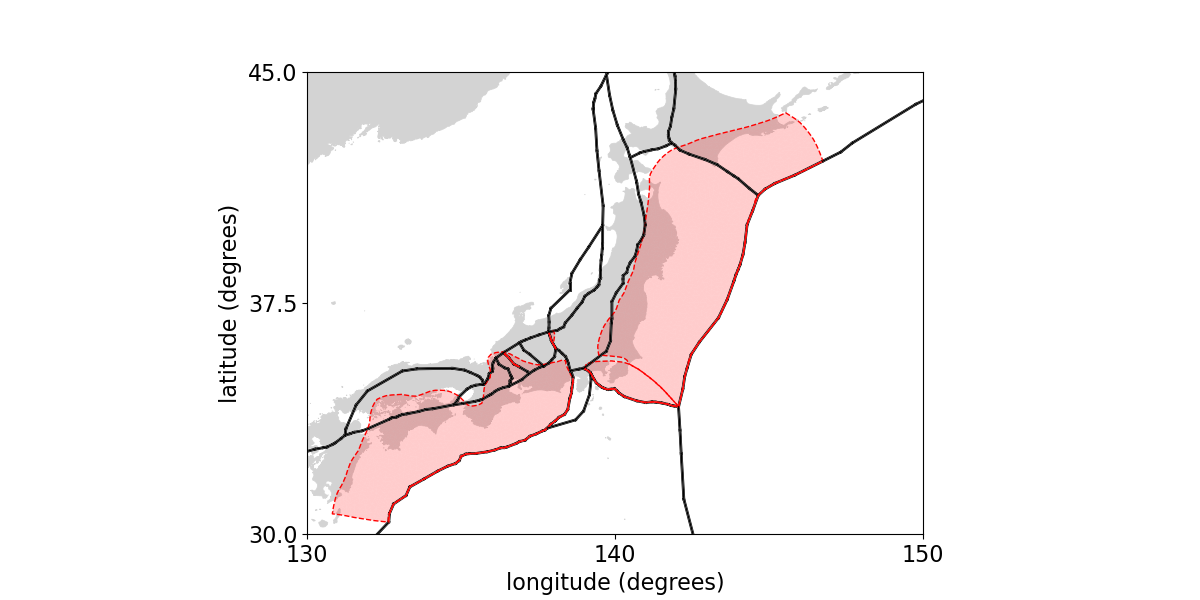

In [15]:
# Get a default plotting parameter dictionary
estimation = {"strike_slip_rates": 0, "dip_slip_rates": 0, "tensile_slip_rates": 0}
estimation = addict.Dict(estimation)
p = celeri.get_default_plotting_dict(command, estimation, station)

# Read in revised inputs
command = celeri.get_command(new_command_file_name)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
celeri.plot_fault_geometry(p, segment, meshes)